In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
last_index = 0
all_codones_dict = {}
all_codones_indices = []

def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq
    
    def to_int(codon):
        if codon in all_codones_dict:
            return all_codones_dict[codon]
        global last_index
        all_codones_dict[codon] = last_index
        all_codones_indices.append(codon)
        last_index += 1
        return last_index - 1
    return [to_int(cropped_seq[i:i+3]) for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []
    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    #if os.path.isfile(read_path):
    #    print('reading', read_path)
    #    with open(read_path, 'rb') as fp:
    #        return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

saving data/all_codones.pickle


In [7]:
counts = [0] * len(all_codones_indices)
for sublist in all_codones:
    for item in sublist:
        counts[item] += 1
        
counts = torch.FloatTensor(counts)
distr = counts / counts.sum()
distr = distr.pow(3 / 4)
distr = distr / distr.sum()
distr = distr.numpy()

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            for target in index_words[max(0, index - context): index]:
                yield center, target
            for target in index_words[index + 1: index + context + 1]:
                yield center, target

def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        pos_target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], pos_target_batch[index] = next(iterator)
        neg_target_batch = np.random.choice(len(all_codones_dict), size=(BATCH_SIZE, NUM_SAMPLED), p=distr)
        yield torch.tensor(center_batch, dtype=torch.long), torch.tensor(pos_target_batch, dtype=torch.long), torch.tensor(neg_target_batch, dtype=torch.long)

def process_data(all_codones, dictionary, batch_size, skip_window):
    single_gen = generate_sample(all_codones, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [12]:
BATCH_SIZE = 64
SKIP_WINDOW = 8  # the context window

batch_gen = process_data(all_codones, all_codones_dict, BATCH_SIZE, SKIP_WINDOW)

In [19]:
class SkipGramModel(nn.Module):
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size):
        super(SkipGramModel, self).__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.center_embedding = nn.Embedding(vocab_size, embed_size, sparse=True)
        self.context_embedding = nn.Embedding(vocab_size, embed_size, sparse=True)
    
    def forward(self, centers, contexts_pos, contexts_neg):
        embedded_centers = self.center_embedding(centers)
        embedded_contexts = self.context_embedding(contexts_pos)
        embedded_neg_contexts = self.context_embedding(contexts_neg)
        
        score = torch.bmm(embedded_centers.view(self.batch_size, 1, self.embed_size), embedded_contexts.view(self.batch_size, self.embed_size, 1)).view(self.batch_size)
        log_target = F.logsigmoid(score)
        
        neg_score = torch.bmm(embedded_neg_contexts, embedded_centers.view(self.batch_size, self.embed_size, 1)).view(self.batch_size, -1)
        log_sampled = F.logsigmoid(-neg_score)
        return (-torch.cat((log_target.unsqueeze(1), log_sampled), 1)).mean()
        
    def get_embeddings(self):
        with torch.no_grad():
            return self.center_embedding(torch.tensor([i for i in range(self.vocab_size)], dtype=torch.long))

In [22]:
VOCAB_SIZE = len(all_codones_dict)
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = 0.1
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE)

In [23]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    writer = SummaryWriter('checkpoints')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
    for index in range(num_train_steps):
        centers, pos_targets, neg_targets = next(batch_gen)
        optimizer.zero_grad()
        loss = model(centers, pos_targets, neg_targets)
        loss.backward()
        optimizer.step()
            
        writer.add_scalar('Training loss', loss, index)
        total_loss += loss
        if (index + 1) % skip_step == 0:
            print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
            writer.add_scalar('Average training loss', total_loss / skip_step, (index + 1) / skip_step)
            total_loss = 0.0
            
    embeggings = model.get_embeddings()
    writer.add_embedding(embeggings)
    return embeggings

In [24]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999:   4.0
Average loss at step 3999:   4.0
Average loss at step 5999:   4.0
Average loss at step 7999:   4.0
Average loss at step 9999:   4.0
Average loss at step 11999:   4.0
Average loss at step 13999:   3.9
Average loss at step 15999:   3.9
Average loss at step 17999:   3.9
Average loss at step 19999:   3.9
Average loss at step 21999:   3.8
Average loss at step 23999:   3.7
Average loss at step 25999:   3.7
Average loss at step 27999:   3.7
Average loss at step 29999:   3.7
Average loss at step 31999:   3.6
Average loss at step 33999:   3.6
Average loss at step 35999:   3.5
Average loss at step 37999:   3.7
Average loss at step 39999:   3.8
Average loss at step 41999:   3.7
Average loss at step 43999:   3.7
Average loss at step 45999:   3.7
Average loss at step 47999:   3.7
Average loss at step 49999:   3.6
Average loss at step 51999:   3.6
Average loss at step 53999:   3.5
Average loss at step 55999:   3.5
Average loss at step 57999:   3.5
Average loss at ste

In [25]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [26]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(all_codones_dict, key=all_codones_dict.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-1.769501,0.441554,MAF
1,1.438609,-0.123218,SAE
2,-0.959175,-1.363865,DVL
3,-2.329651,3.589886,KEY
4,3.647755,0.307165,DRR


In [27]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

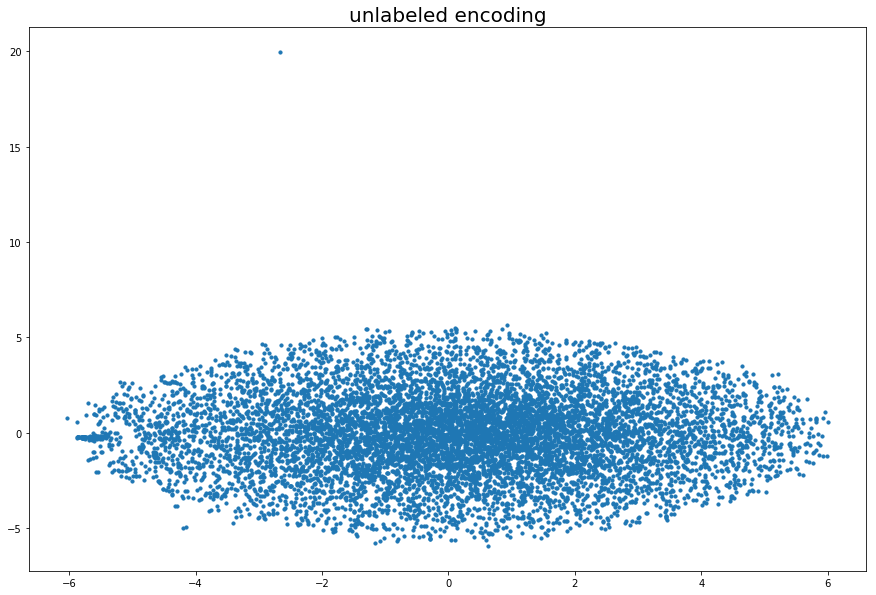

In [28]:
plot_tsne_df(tsne_df)

In [29]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [30]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [31]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [32]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,MAF,2.166667,116.482633,18.666667,147.133333
1,SAE,-0.833333,95.756400,15.333333,105.333333
2,DVL,1.500000,109.125367,19.000000,139.266667
3,KEY,-2.900000,140.153200,22.333333,166.866667
4,DRR,-4.166667,142.486267,22.666667,152.633333


In [33]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,MAF,2.166667,116.482633,18.666667,147.133333,-1.769501,0.441554
1,SAE,-0.833333,95.756400,15.333333,105.333333,1.438609,-0.123218
2,DVL,1.500000,109.125367,19.000000,139.266667,-0.959175,-1.363865
3,KEY,-2.900000,140.153200,22.333333,166.866667,-2.329651,3.589886
4,DRR,-4.166667,142.486267,22.666667,152.633333,3.647755,0.307165


In [34]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

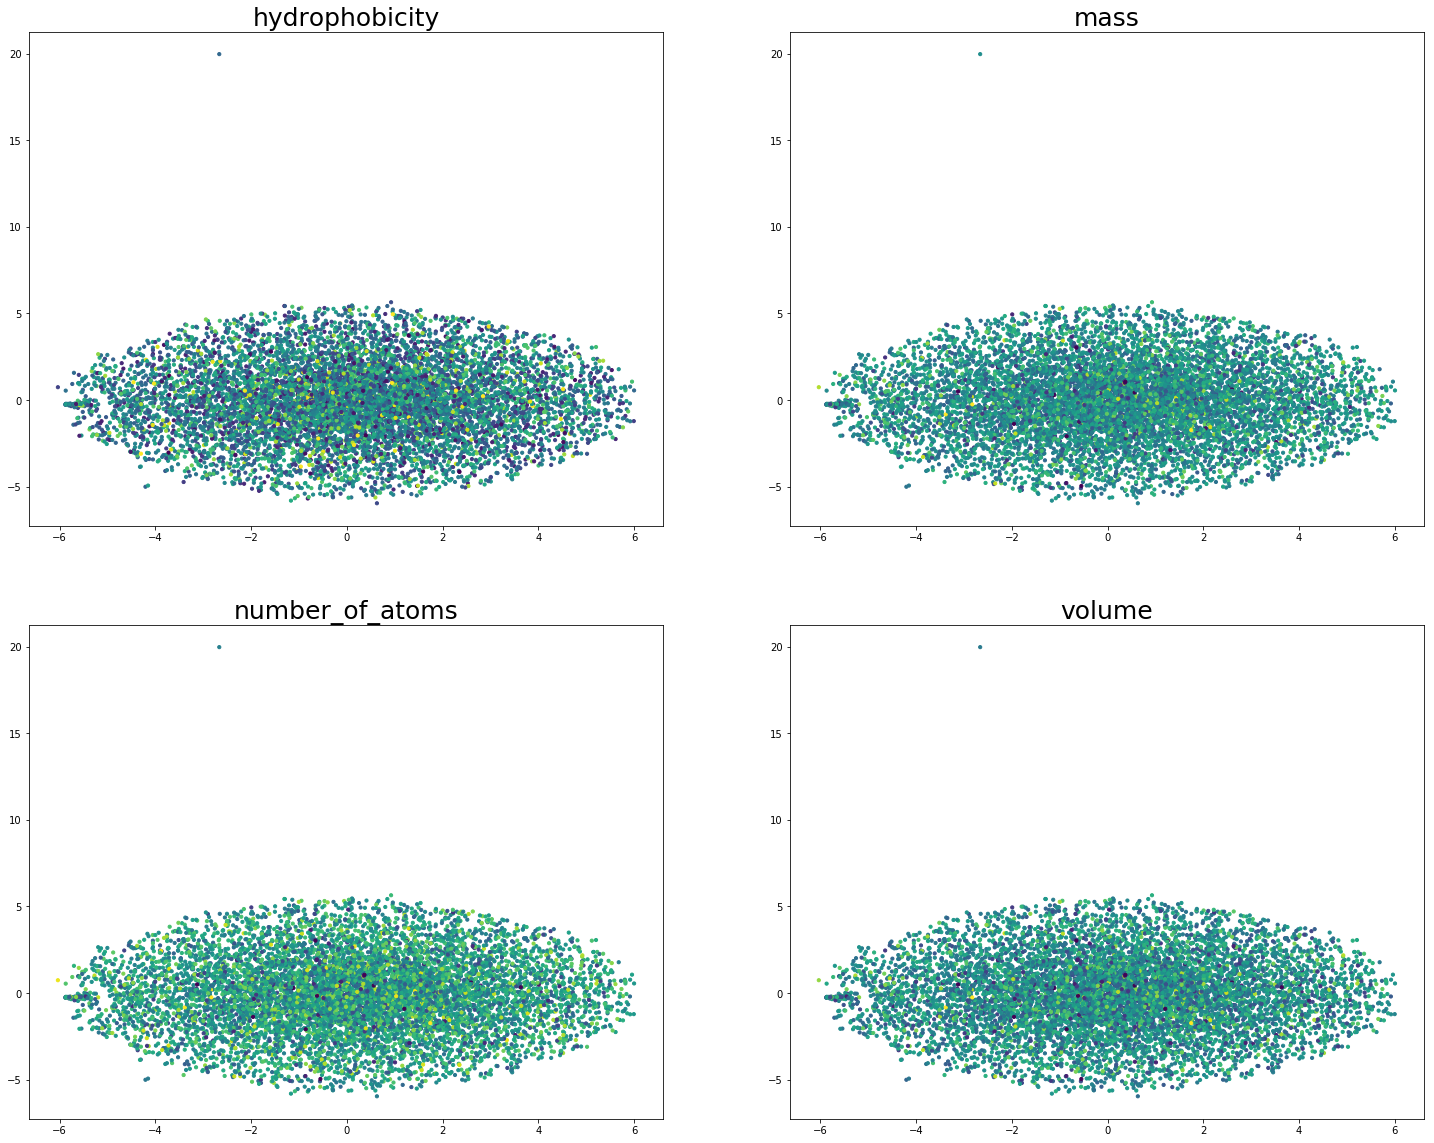

In [35]:
plot_embedding_properties(final_df)

In [36]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

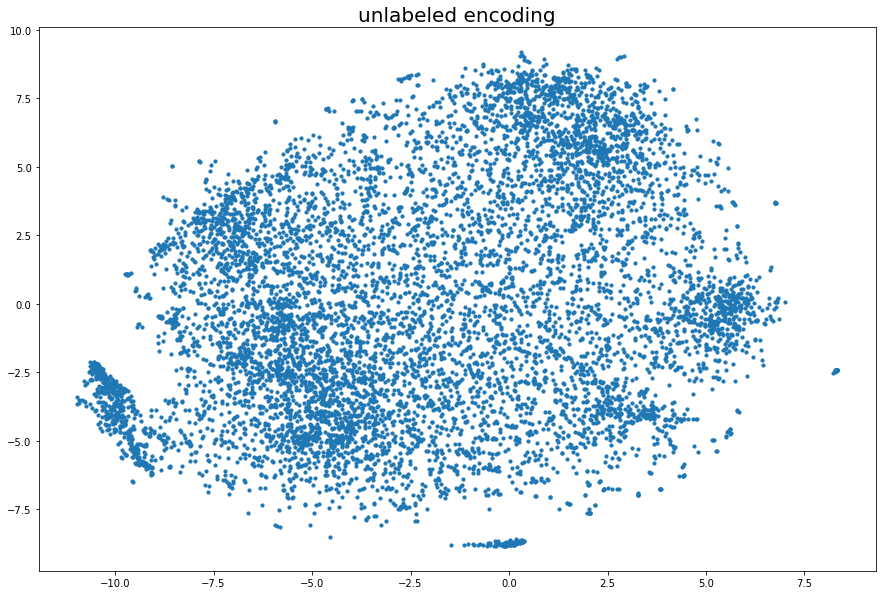

In [37]:
plot_tsne_df(gensim_tsne_df)

In [38]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

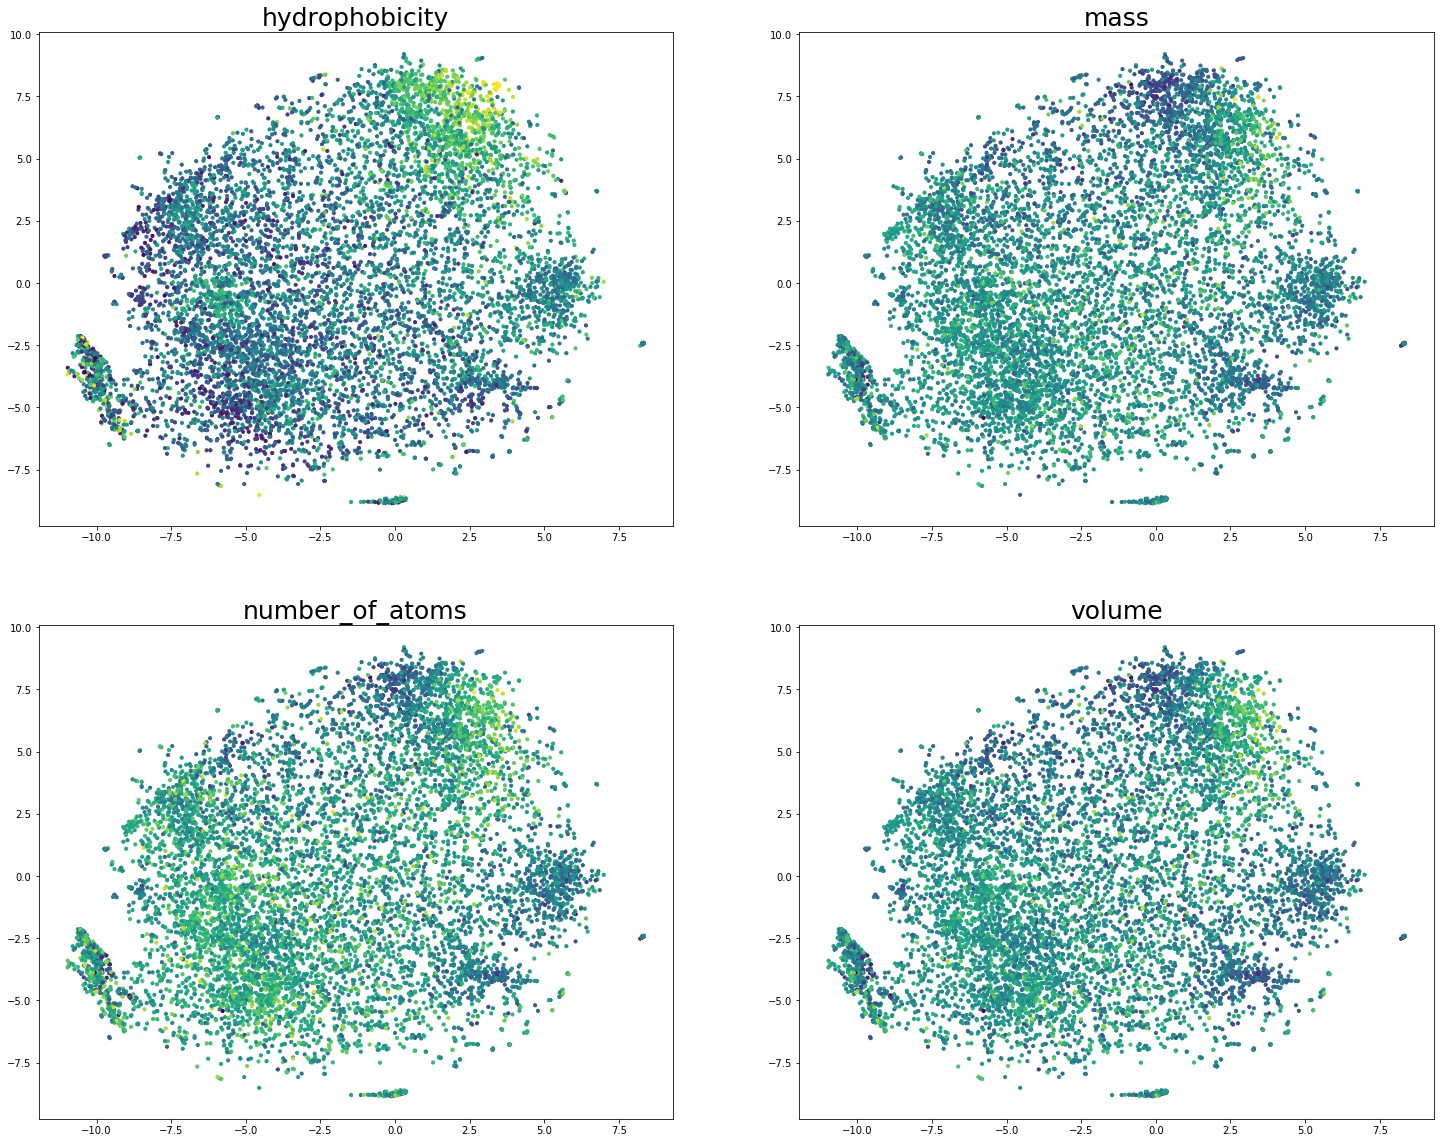

In [39]:
plot_embedding_properties(final_df_nice)